# Identifying Sepsis Phenotypes With K-Means Clustering Using A Large Public Database - ECMM445 Cousework Project

In this notebook, I intended to explore the phenotypes of sepsis patients with K-means clustering utilising the Medical Information Mart for Intensive Care (MIMIC)-IV database.

# Import data

In [ ]:
pip install lifelines

In [150]:
# Importing libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.spatial.distance import cdist
from lifelines import KaplanMeierFitter

In [3]:
df = pd.read_csv('sepsis.csv')

# Statistical summary

In [7]:
pd.set_option('display.max_columns', None)
df.head()

,subject_id,hadm_id,stay_id,gender,admission_age,race,dod,hospital_expire_flag,los_hospital,hospstay_seq,icustay_seq,los_icu,los_hosp_icu,anti_gap,cul_gap,sepsis_gap,height,weight,first_careunit,admission_type,admission_location,insurance,marital_status,anchor_year_group,MI,CHF,CVD,cpd,ckd,diabetes,cancer,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,mbp_min,mbp_max,mbp_mean,resp_rate_min,resp_rate_max,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,spo2_mean,wbc_min,wbc_max,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,crp_max,crp_min,mch_max,mch_min,mchc_max,mchc_min,mcv_max,mcv_min,rbc_max,rbc_min,rdw_max,rdw_min,neut_max,neut_min,lymp_max,lymp_min,nlr_max,nlr_min,bun_min,bun_max,creatinine_min,creatinine_max,bicarbonate_min,bicarbonate_max,sodium_min,sodium_max,potassium_min,potassium_max,chloride_min,chloride_max,calcium_min,calcium_max,aniongap_min,aniongap_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,alt_min,alt_max,alp_min,alp_max,ast_min,ast_max,bilirubin_total_min,bilirubin_total_max,bilirubin_direct_min,bilirubin_direct_max,bilirubin_indirect_min,bilirubin_indirect_max,ggt_min,ggt_max,amylase_min,amylase_max,ld_ldh_min,ld_ldh_max,glucose_min,glucose_max,ck_max,ck_min,probnp_max,probnp_min,pt_min,pt_max,ptt_min,ptt_max,inr_min,inr_max,fibrinogen_min,fibrinogen_max,thrombin_min,thrombin_max,d_dimer_min,d_dimer_max,lactate_min,lactate_max,ph_min,ph_max,BE_min,BE_max,totalco2_min,totalco2_max,po2_min,po2_max,pco2_min,pco2_max,aado2_min,aado2_max,OI_min,OI_max,uo_firstday,gcs_min,rrt_flag,peritoneal,ihd,scuf,cvvh,cvvhd,cvvhdf,invasive,noninvasive,ox,hfhc,dobutamine_flag,max_dobutamine,dopamine_flag,max_dopamine,epinephrine_flag,max_epinephrine,norepinephrine_flag,max_norepinephrine,phenylephrine_flag,max_phenylephrine,vasopressin_flag,max_vasopressin,PN_flag,EN_flag,d1_calories,protein_sum,volume_sum,d1_insulin,blood,resp,csf,gi,gu,other,sofa_score,LODS,SAPSII,SAPSIII,OASIS,seqnum
0,10001884,26184834,37510196,F,77,BLACK/AFRICAN AMERICAN,2131-01-20,1,13,1,1,9.17,9.04,3.67,-11.73,0.67,157.0,65.0,Medical Intensive Care Unit (MICU),OBSERVATION ADMIT,EMERGENCY ROOM,Medicare,MARRIED,2008 - 2010,0,0,0,1,0,0,0,38.0,80.0,71.392857,93.0,180.0,123.730769,12.0,123.0,72.884615,46.0,130.0,86.038462,10.0,26.0,17.775862,35.10,37.20,36.573684,89.0,100.0,98.259259,12.0,18.4,33.6,36.0,10.4,11.4,149.0,171.0,NaN,NaN,28.4,28.3,31.7,31.0,91.0,90.0,4.01,3.68,17.8,17.6,92.0,92.0,3.0,3.0,30.666667,30.666667,26.0,30.0,1.0,1.1,33.0,33.0,136.0,138.0,4.0,4.2,96.0,98.0,8.7,9.8,11.0,11.0,3.5,3.5,NaN,NaN,NaN,NaN,116.0,167.0,48.0,55.0,55.0,134.0,0.2,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.0,148.0,14.0,14.0,NaN,NaN,13.5,15.3,21.3,150.0,1.2,1.4,NaN,NaN,NaN,NaN,NaN,NaN,1.1,1.7,7.22,7.37,2.0,7.0,33.0,40.0,74.0,74.0,94.0,94.0,NaN,NaN,NaN,NaN,1560.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1,10.006255,0,NaN,0,NaN,0,NaN,0,NaN,0.0,0.0,324.047546,0.0,1697.478103,0.00000,0,0,0,0,0,0,3,7,44,51,31,1
1,10002013,23581541,39060235,F,57,OTHER,NaN,0,5,1,1,1.31,5.15,1.00,4.67,5.00,157.0,96.0,Cardiac Vascular Intensive Care Unit (CVICU),SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,SINGLE,2008 - 2010,1,1,0,1,0,1,0,80.0,105.0,94.636364,80.0,143.0,110.120000,51.0,81.0,62.200000,41.0,100.5,75.980000,11.0,23.0,15.409091,36.22,37.70,37.242353,92.0,100.0,97.050000,17.9,20.2,28.6,31.9,10.2,11.2,248.0,254.0,NaN,NaN,34.8,33.9,35.7,35.0,98.0,97.0,3.30,2.95,13.2,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,16.0,0.9,1.1,23.0,23.0,136.0,140.0,4.0,4.7,106.0,109.0,NaN,NaN,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,98.0,NaN,NaN,NaN,NaN,11.3,12.7,25.4,27.2,1.0,1.2,212.0,212.0,NaN,NaN,NaN,NaN,2.3,3.3,7.27,7.40,-4.0,0.0,23.0,27.0,90.0,462.0,41.0,56.0,NaN,NaN,180.0,332.0,1640.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0,NaN,0,NaN

In [31]:
# exclude multiple admissions
df = df.loc[df['icustay_seq'] == 1]

In [ ]:
for col in df.columns:
    print(col)

In [32]:
to_find = ['gender','admission_age','MI','CHF','CVD','cpd','ckd','diabetes','cancer',
          'heart_rate_mean','sbp_mean','dbp_mean','resp_rate_mean','temperature_mean',
          'spo2_mean','wbc_max','hemoglobin_min','platelets_min','bun_max',
          'creatinine_max','bicarbonate_min','sodium_min','potassium_max','chloride_max',
          'aniongap_max','albumin_min','alt_max','ast_max','bilirubin_total_max','glucose_max',
          'inr_max','lactate_max','po2_min','pco2_max','uo_firstday','gcs_min']

df1 = df[to_find]

In [33]:
df1.shape

(23374, 36)

In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23374 entries, 0 to 24271
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               23374 non-null  object 
 1   admission_age        23374 non-null  int64  
 2   MI                   23374 non-null  int64  
 3   CHF                  23374 non-null  int64  
 4   CVD                  23374 non-null  int64  
 5   cpd                  23374 non-null  int64  
 6   ckd                  23374 non-null  int64  
 7   diabetes             23374 non-null  int64  
 8   cancer               23374 non-null  int64  
 9   heart_rate_mean      23349 non-null  float64
 10  sbp_mean             23277 non-null  float64
 11  dbp_mean             23276 non-null  float64
 12  resp_rate_mean       23339 non-null  float64
 13  temperature_mean     22228 non-null  float64
 14  spo2_mean            23344 non-null  float64
 15  wbc_max              23331 non-null 

In [40]:
# transform gender variable
df1['gender'] = np.where(df1['gender'] == 'F', 0, 1)

In [41]:
# change into categories
df1 = df1.assign(gender = lambda x: pd.Categorical(x['gender']),
                MI = lambda x: pd.Categorical(x['MI']),
                CHF = lambda x: pd.Categorical(x['CHF']),
                CVD = lambda x: pd.Categorical(x['CVD']),
                cpd = lambda x: pd.Categorical(x['cpd']),
                ckd = lambda x: pd.Categorical(x['ckd']),
                diabetes = lambda x: pd.Categorical(x['diabetes']),
                cancer = lambda x: pd.Categorical(x['cancer']))

In [43]:
df1.head()

,gender,admission_age,MI,CHF,CVD,cpd,ckd,diabetes,cancer,heart_rate_mean,sbp_mean,dbp_mean,resp_rate_mean,temperature_mean,spo2_mean,wbc_max,hemoglobin_min,platelets_min,bun_max,creatinine_max,bicarbonate_min,sodium_min,potassium_max,chloride_max,aniongap_max,albumin_min,alt_max,ast_max,bilirubin_total_max,glucose_max,inr_max,lactate_max,po2_min,pco2_max,uo_firstday,gcs_min
0,0,77,0,0,0,1,0,0,0,71.392857,123.730769,72.884615,17.775862,36.573684,98.259259,18.4,10.4,149.0,30.0,1.1,33.0,136.0,4.2,98.0,11.0,3.5,167.0,134.0,0.4,148.0,1.4,1.7,74.0,94.0,1560.0,15.0
1,0,57,1,1,0,1,0,1,0,94.636364,110.120000,62.200000,15.409091,37.242353,97.050000,20.2,10.2,248.0,16.0,1.1,23.0,136.0,4.7,109.0,12.0,NaN,NaN,NaN,NaN,98.0,1.2,3.3,90.0,56.0,1640.0,15.0
2,0,81,1,1,0,0,1,0,1,73.720000,108.583333,55.000000,16.080000,36.294286,92.640000,7.9,12.1,165.0,22.0,1.2,24.0,139.0,4.7,106.0,15.0,NaN,NaN,NaN,NaN,138.0,1.0,NaN,76.0,48.0,2000.0,15.0
3,0,77,0,0,0,0,0,0,1,64.880000,121.066667,70.866667,18.600000,36.731667,93.760000,4.3,13.0,273.0,26.0,0.8,23.0,142.0,4.8,107.0,12.0,NaN,NaN,NaN,NaN,127.0,1.0,NaN,NaN,NaN,325.0,14.0
5,1,53,0,0,0,0,0,1,0,94.344828,115.392857,75.750000,23.517241,36.810000,93.000000,20.7,14.2,282.0,24.0,0.9,18.0,132.0,5.3,106.0,12.0,3.4,80.0,68.0,0.5,276.0,1.3,1.9,74.0,49.0,3450.0,15.0


In [42]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
admission_age,23374.0,66.037649,16.205095,18.000000,56.000000,68.000000,78.000000,102.000000
heart_rate_mean,23349.0,86.889888,16.055601,33.612903,75.586207,85.241379,97.185185,161.441860
sbp_mean,23277.0,115.708231,15.246634,57.465116,105.062500,113.211538,124.073171,206.388889
dbp_mean,23276.0,61.371069,10.265483,22.500000,54.480000,60.250000,67.000000,130.388889
resp_rate_mean,23339.0,19.611245,4.030246,8.695652,16.703704,18.951613,21.912404,44.433333
temperature_mean,22228.0,36.890269,0.605711,31.200000,36.595804,36.858571,37.207500,40.104118
spo2_mean,23344.0,97.020023,2.168875,54.095238,95.862069,97.307692,98.576923,100.000000
wbc_max,23331.0,15.581696,11.808736,0.100000,10.000000,13.800000,18.700000,462.600000
hemoglobin_min,23329.0,9.831909,2.144024,1.700000,8.300000,9.700000,11.300000,18.900000
platelets_min,23331.0,177.712743,102.694634,5.000000,110.000000,159.000000,224.000000,1592.000000


In [44]:
df1.describe().T.to_excel("summary.xlsx")

# Data visualization

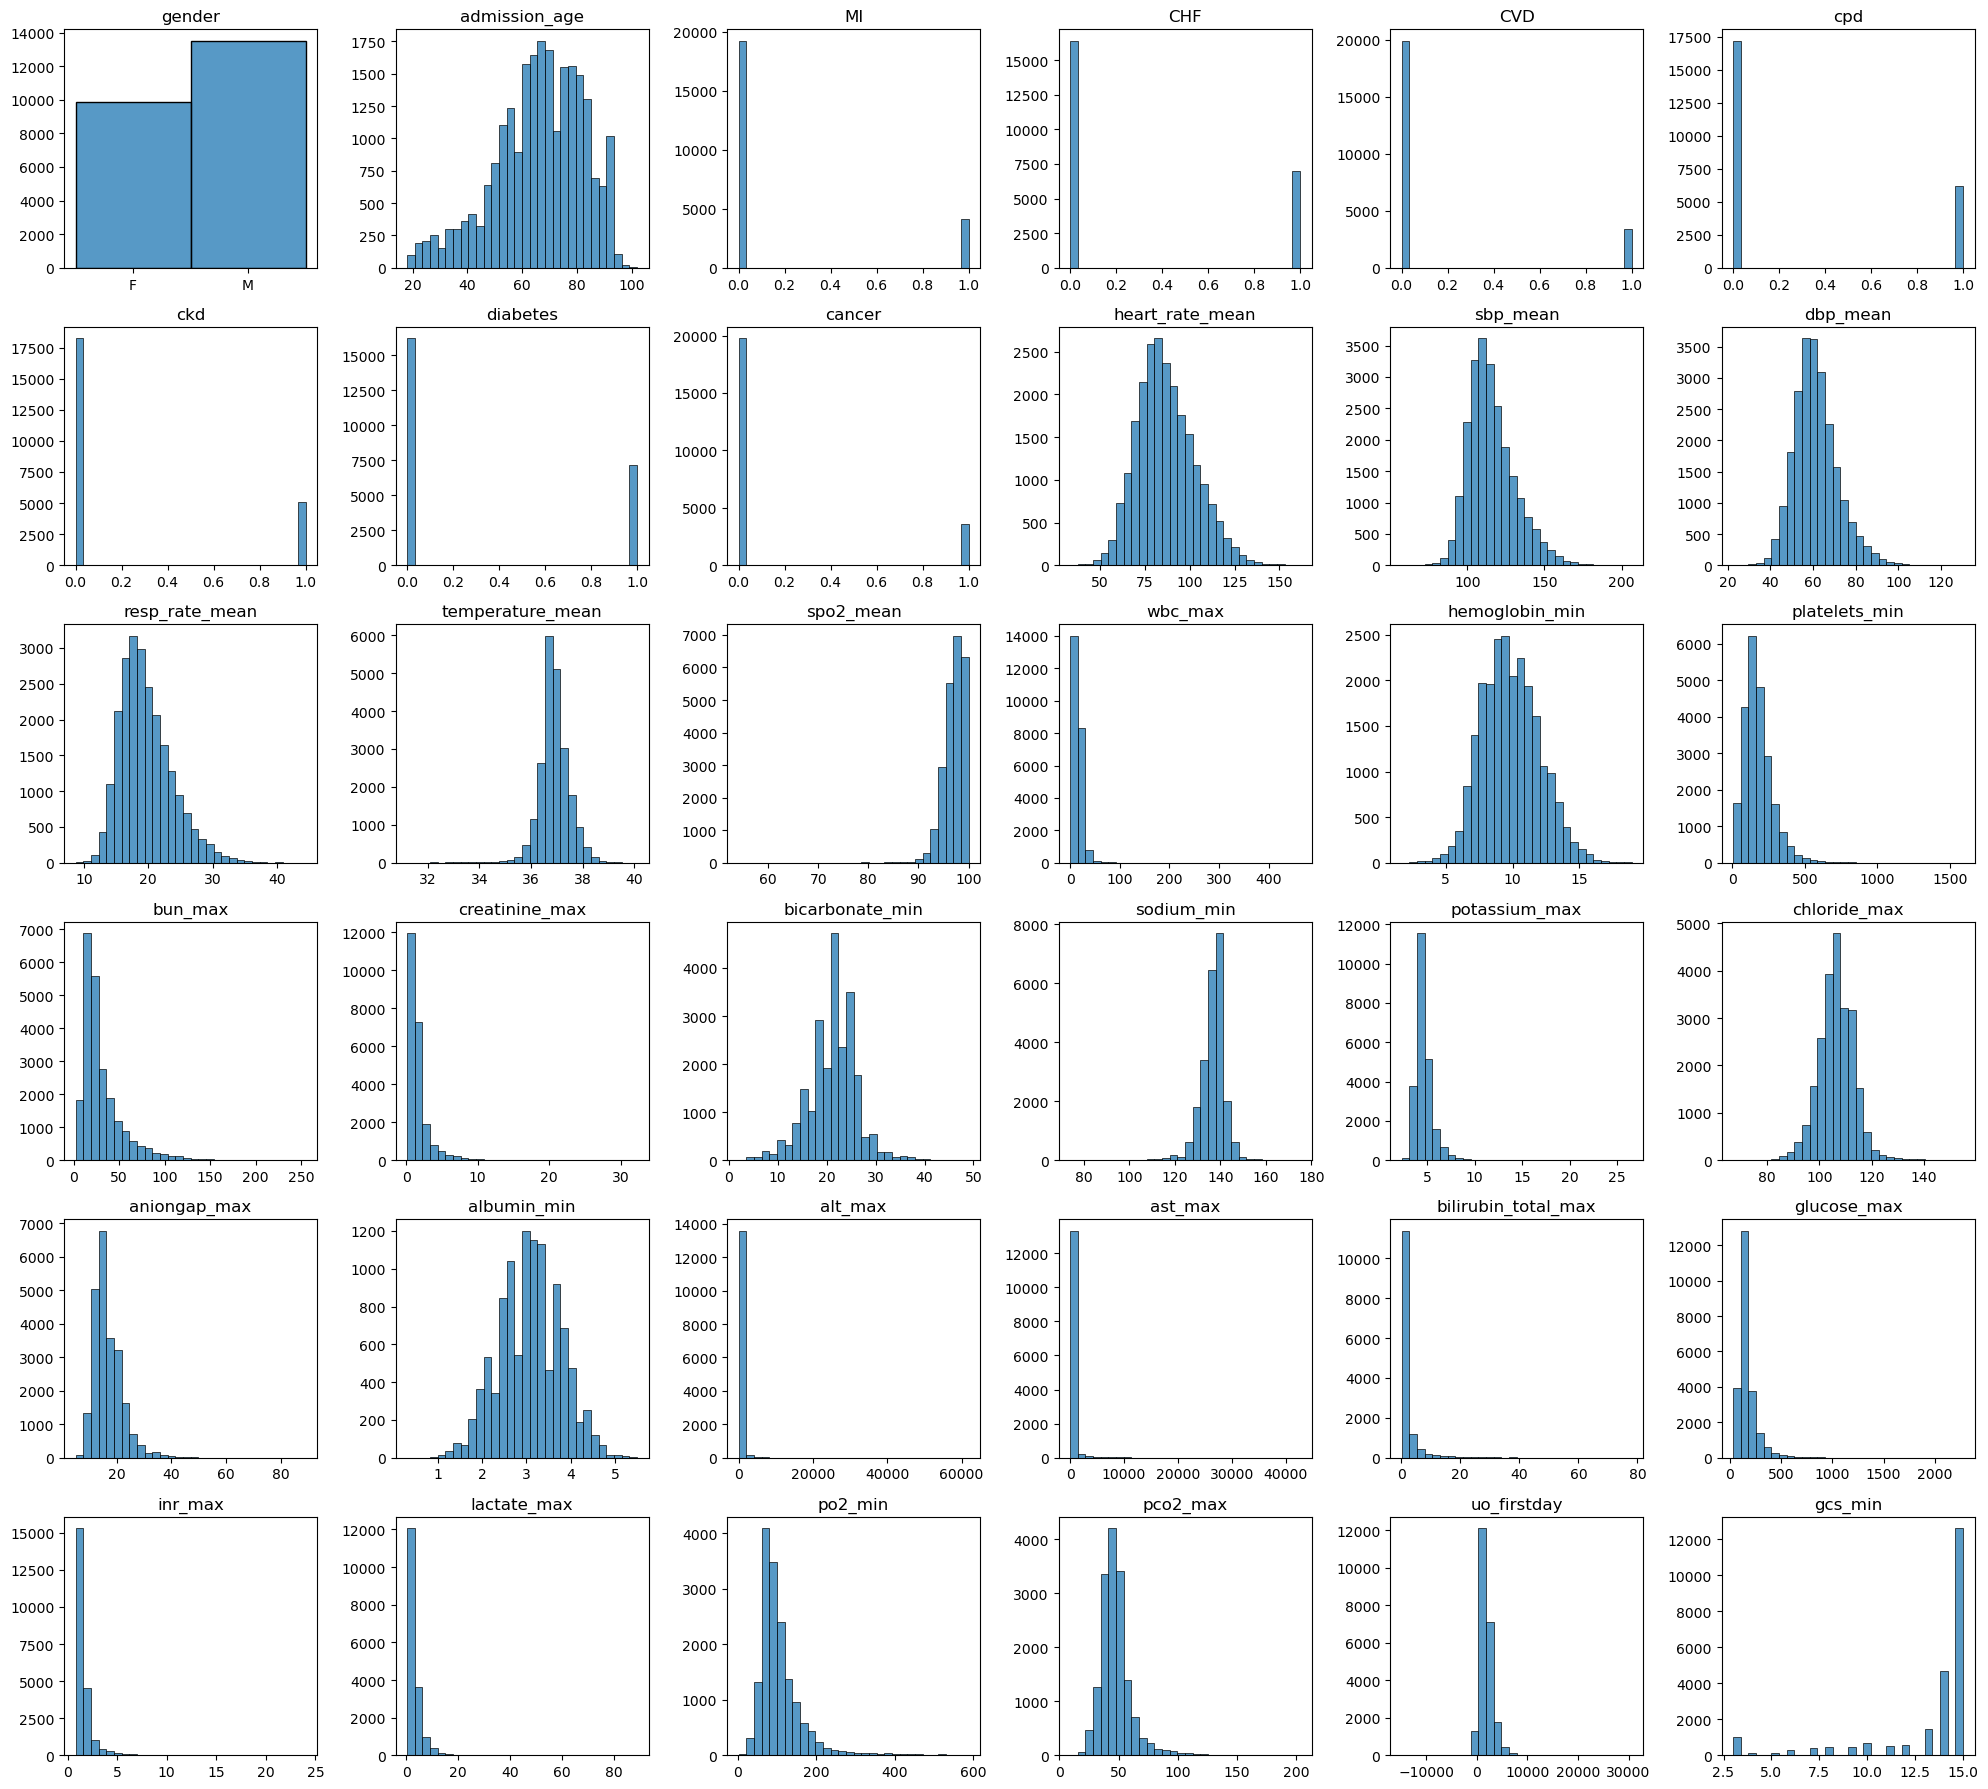

In [56]:
# histogram
num_columns = 6
num_rows = 6

fig0 = plt.figure(figsize=(20, 3 * 6))

for i, column in enumerate(df1.columns):
    plt.subplot(num_rows, num_columns, i + 1)
    sns.histplot(df[column], kde=False, bins=30)
    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [57]:
fig0.savefig('histogram.png', dpi=300, bbox_inches='tight')

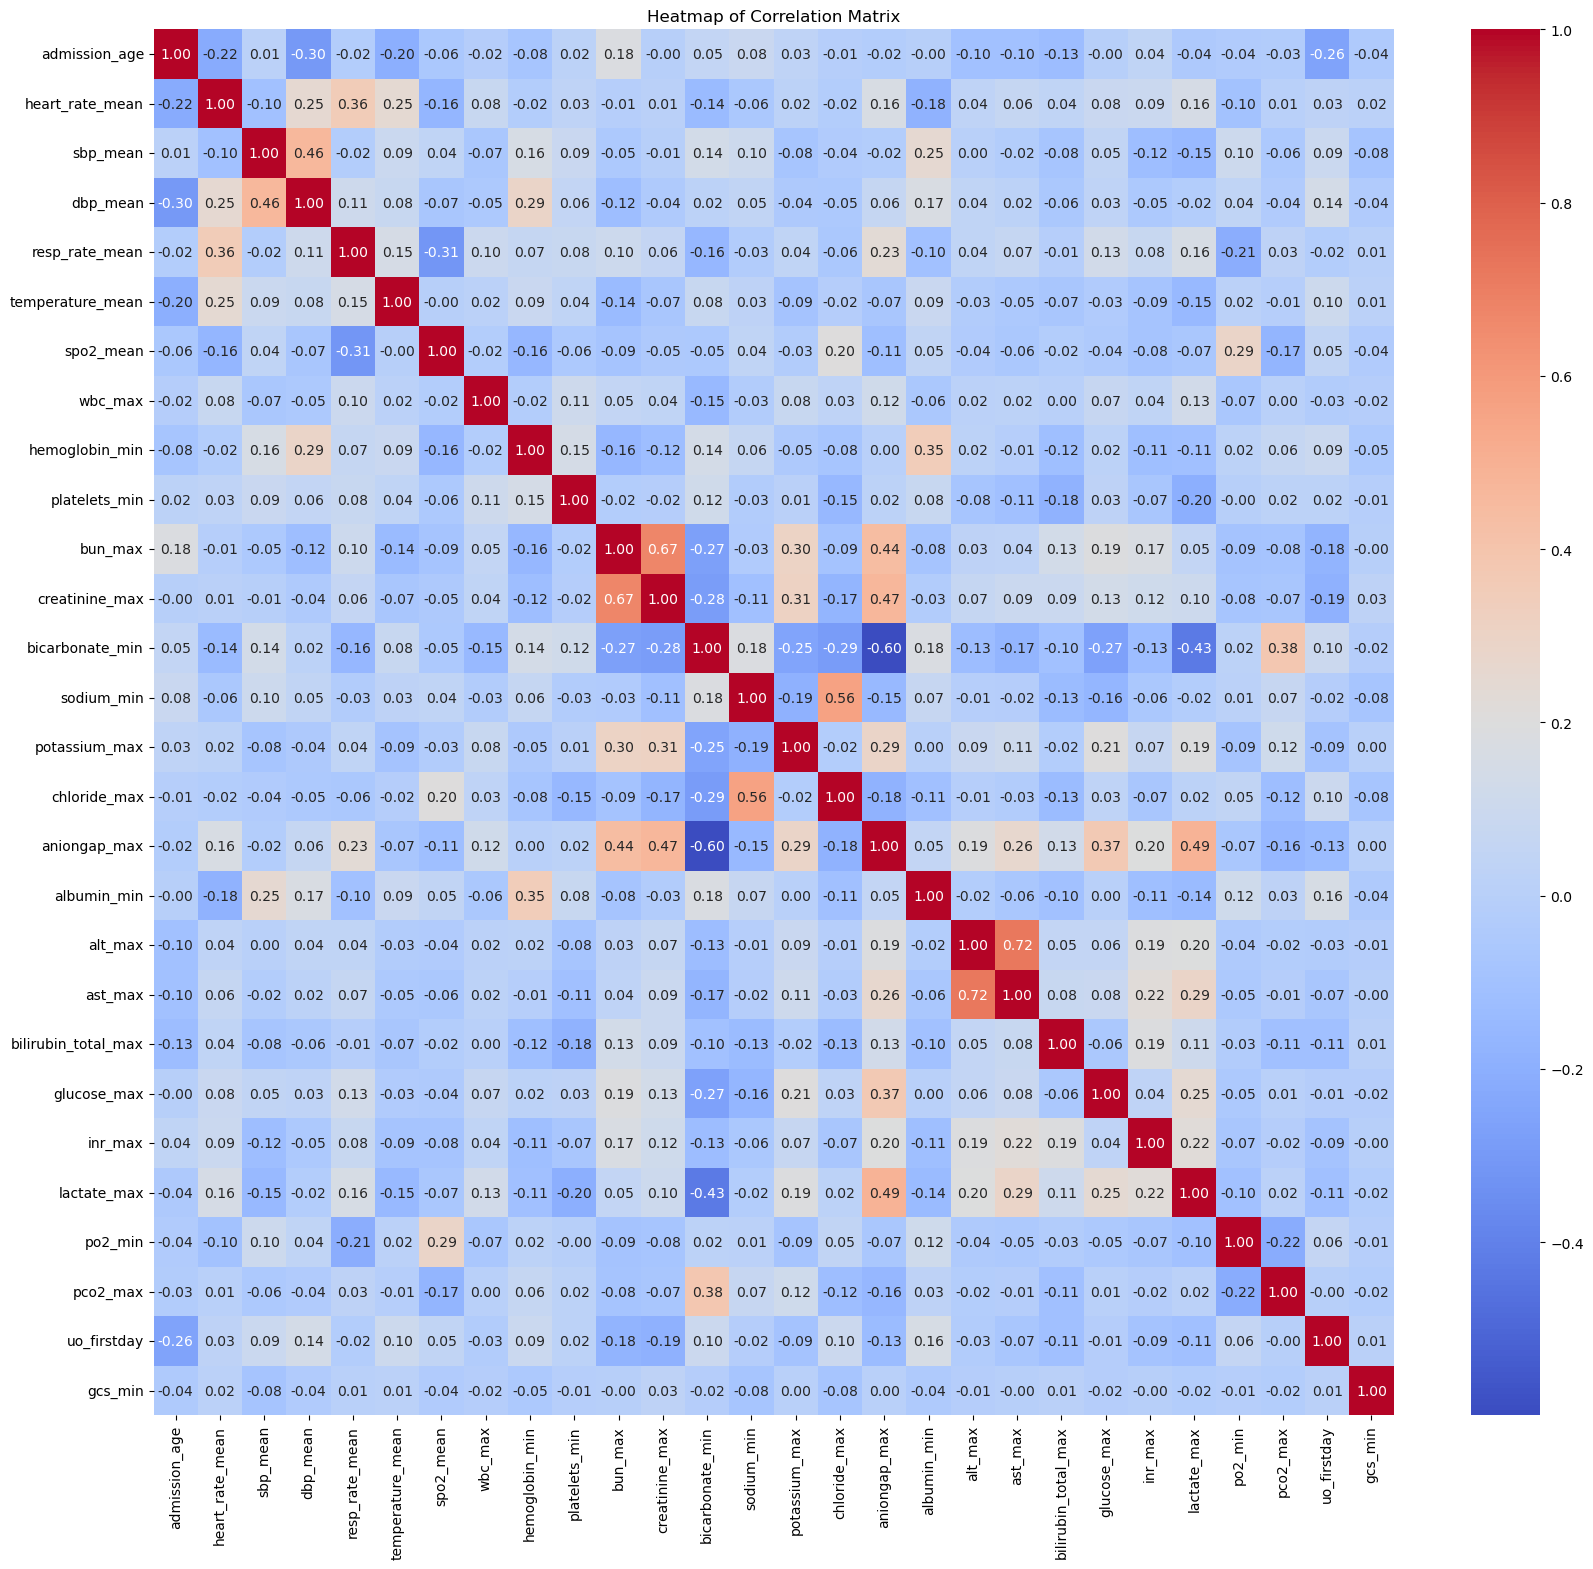

In [46]:
# heatmap
fig = plt.figure(figsize=(20, 18))
sns.heatmap(df1.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [47]:
fig.savefig('heatmap.png', dpi=300, bbox_inches='tight')

# Data pre-processing

In [64]:
# wrong values
df1.loc[df1['uo_firstday'] < 0]

,gender,admission_age,MI,CHF,CVD,cpd,ckd,diabetes,cancer,heart_rate_mean,sbp_mean,dbp_mean,resp_rate_mean,temperature_mean,spo2_mean,wbc_max,hemoglobin_min,platelets_min,bun_max,creatinine_max,bicarbonate_min,sodium_min,potassium_max,chloride_max,aniongap_max,albumin_min,alt_max,ast_max,bilirubin_total_max,glucose_max,inr_max,lactate_max,po2_min,pco2_max,uo_firstday,gcs_min
2770,1,72,1,1,1,0,1,1,0,105.565217,122.833333,80.708333,25.478261,37.15600,93.739130,15.4,12.2,205.0,30.0,1.9,24.0,144.0,4.0,109.0,17.0,NaN,51.0,178.0,NaN,380.0,1.1,NaN,NaN,NaN,-1305.0,9.0
4407,1,80,0,1,1,0,0,1,1,114.565217,93.500000,59.590909,14.826087,36.52750,95.600000,NaN,NaN,NaN,77.0,2.0,15.0,132.0,7.3,100.0,29.0,NaN,29.0,69.0,0.6,191.0,NaN,NaN,NaN,NaN,-14850.0,15.0
5712,0,87,0,0,0,0,0,0,1,97.280000,120.500000,61.208333,19.800000,36.93750,97.360000,20.6,7.5,197.0,35.0,2.0,17.0,121.0,4.9,96.0,19.0,NaN,NaN,NaN,NaN,123.0,1.1,NaN,NaN,NaN,-1800.0,15.0
13108,1,92,0,0,0,0,0,0,0,81.230769,111.208333,57.875000,16.230769,37.63300,97.280000,21.3,7.5,41.0,17.0,1.1,20.0,131.0,3.8,102.0,15.0,4.1,19.0,39.0,0.3,200.0,1.5,NaN,NaN,NaN,-1175.0,10.0
22151,1,84,0,1,0,1,0,0,0,83.153846,128.400000,50.880000,18.384615,36.81500,96.923077,10.0,7.8,164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,1.6,163.0,37.0,-2600.0,15.0
22210,1,95,0,0,0,0,0,1,0,62.680000,126.791667,67.666667,20.720000,36.45875,95.080000,13.9,13.1,93.0,31.0,1.1,27.0,141.0,4.6,106.0,16.0,NaN,NaN,NaN,NaN,127.0,4.1,NaN,62.0,39.0,-2125.0,12.0


In [66]:
# replace with NaN
df1.loc[df1['uo_firstday'] < 0, 'uo_firstday'] = np.NaN

In [69]:
# imput missing values
df1_num = df1.select_dtypes(include=[np.number])
df1[df1_num.columns] = df1_num.fillna(df1_num.mean())

In [72]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
admission_age,23374.0,66.037649,16.205095,18.000000,56.000000,68.000000,78.000000,102.000000
heart_rate_mean,23374.0,86.889888,16.047012,33.612903,75.600000,85.260870,97.170977,161.441860
sbp_mean,23374.0,115.708231,15.214964,57.465116,105.100000,113.272727,124.000000,206.388889
dbp_mean,23374.0,61.371069,10.243939,22.500000,54.504032,60.285714,66.964286,130.388889
resp_rate_mean,23374.0,19.611245,4.027227,8.695652,16.706615,18.960000,21.908670,44.433333
temperature_mean,23374.0,36.890269,0.590675,31.200000,36.611667,36.888000,37.183937,40.104118
spo2_mean,23374.0,97.020023,2.167483,54.095238,95.865315,97.307692,98.571429,100.000000
wbc_max,23374.0,15.581696,11.797868,0.100000,10.000000,13.800000,18.700000,462.600000
hemoglobin_min,23374.0,9.831909,2.141959,1.700000,8.300000,9.700000,11.300000,18.900000
platelets_min,23374.0,177.712743,102.600125,5.000000,110.000000,159.000000,224.000000,1592.000000


In [73]:
# feature standardlisation
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

In [77]:
# PCA for dimension reduction
pca = PCA(n_components=2)
df1_pca = pca.fit_transform(df1_scaled)

# Clustering

In [123]:
# apply K-Means, start from k=3
kmeans = KMeans(n_clusters=3,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42)  
clusters = kmeans.fit_predict(df1_pca)

C:\File\Tool\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


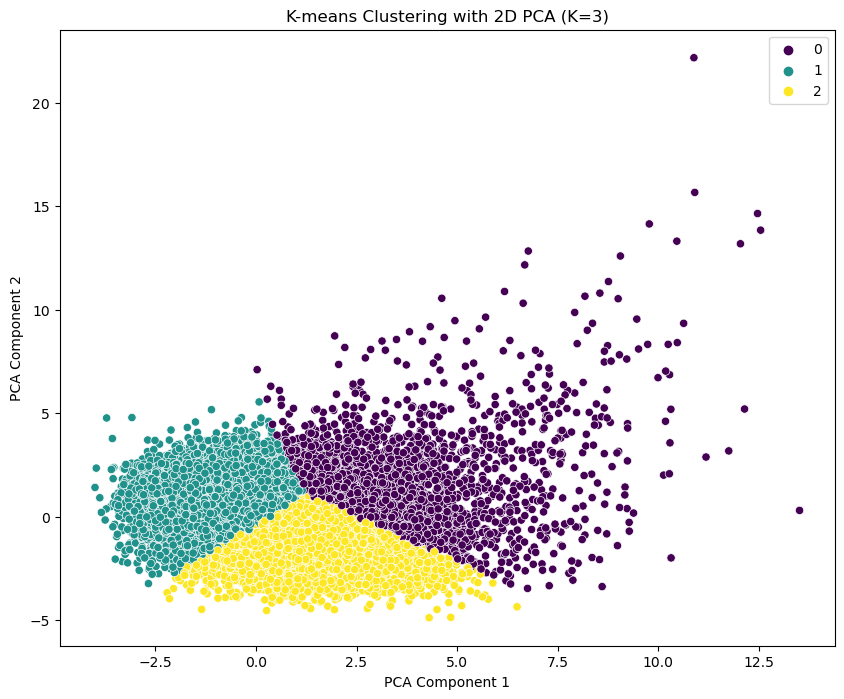

In [124]:
# plot cluster plot for k = 3
figcp = plt.figure(figsize=(10, 8))
sns.scatterplot(df1_pca[:, 0], df1_pca[:, 1], hue=clusters, palette="viridis")
plt.title('K-means Clustering with 2D PCA (K=3)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [119]:
figcp.savefig('cluster plot.png', dpi=300, bbox_inches='tight')

In [126]:
df1['label'] = kmeans.labels_

# Clustering evaluation

### Elbow method

In [86]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1,10)

for k in K:
    kmeanmodel = KMeans(n_clusters=k).fit(df1_pca)
    kmeanmodel.fit(df1_pca)
    
    distortions.append(sum(np.min(cdist(df1_pca, kmeanmodel.cluster_centers_,
                                       'euclidean'), axis=1))/df1_pca.shape[0])
    inertias.append(kmeanmodel.inertia_)
    mapping1[k] = sum(np.min(cdist(df1_pca, kmeanmodel.cluster_centers_,
                                       'euclidean'), axis=1))/df1_pca.shape[0]
    mapping2[k] = kmeanmodel.inertia_

In [87]:
for key,val in mapping1.items():
    print(f'{key}: {val}')

1: 2.0681614184759445
2: 1.5993089982334836
3: 1.3848896131850978
4: 1.236213725167592
5: 1.125541055753418
6: 1.032814668958902
7: 0.9807549915364533
8: 0.9190229055683274
9: 0.873838470812724


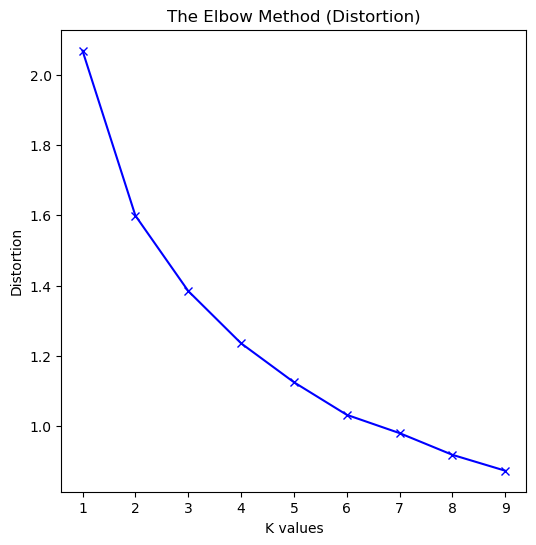

In [93]:
fig1 = plt.figure(figsize=(6, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('K values')
plt.ylabel('Distortion')
plt.title('The Elbow Method (Distortion)')
plt.show()

In [94]:
fig1.savefig('elbow.png', dpi=300, bbox_inches='tight')

In [89]:
for key,val in mapping2.items():
    print(f'{key}: {val}')

1: 145058.15346535272
2: 88688.69953464369
3: 63793.21743818745
4: 51100.11571261115
5: 41740.55231923015
6: 35263.05229973333
7: 31279.58022216321
8: 27587.66046684166
9: 24999.221813178374


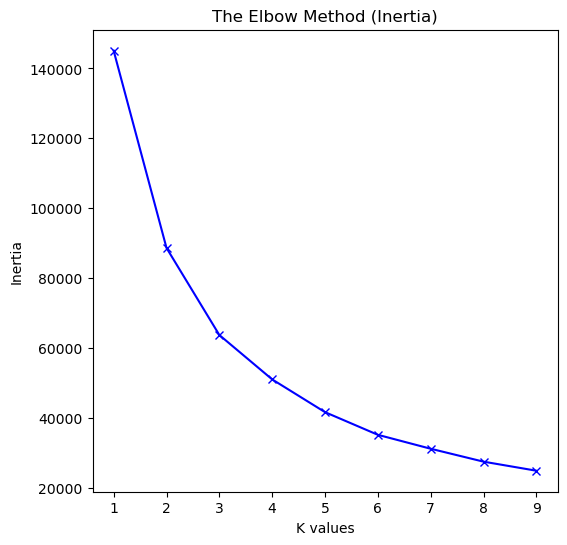

In [95]:
fig2 = plt.figure(figsize=(6, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('K values')
plt.ylabel('Inertia')
plt.title('The Elbow Method (Inertia)')
plt.show()

In [96]:
fig2.savefig('elbow-inertia.png', dpi=300, bbox_inches='tight')

### Silhouette analysis

For 2 clusters, average silhouette score is 0.44743530571173323
For 3 clusters, average silhouette score is 0.39693715621438586
For 4 clusters, average silhouette score is 0.3224946881422461
For 5 clusters, average silhouette score is 0.3448957709431448
For 6 clusters, average silhouette score is 0.33227420754468884


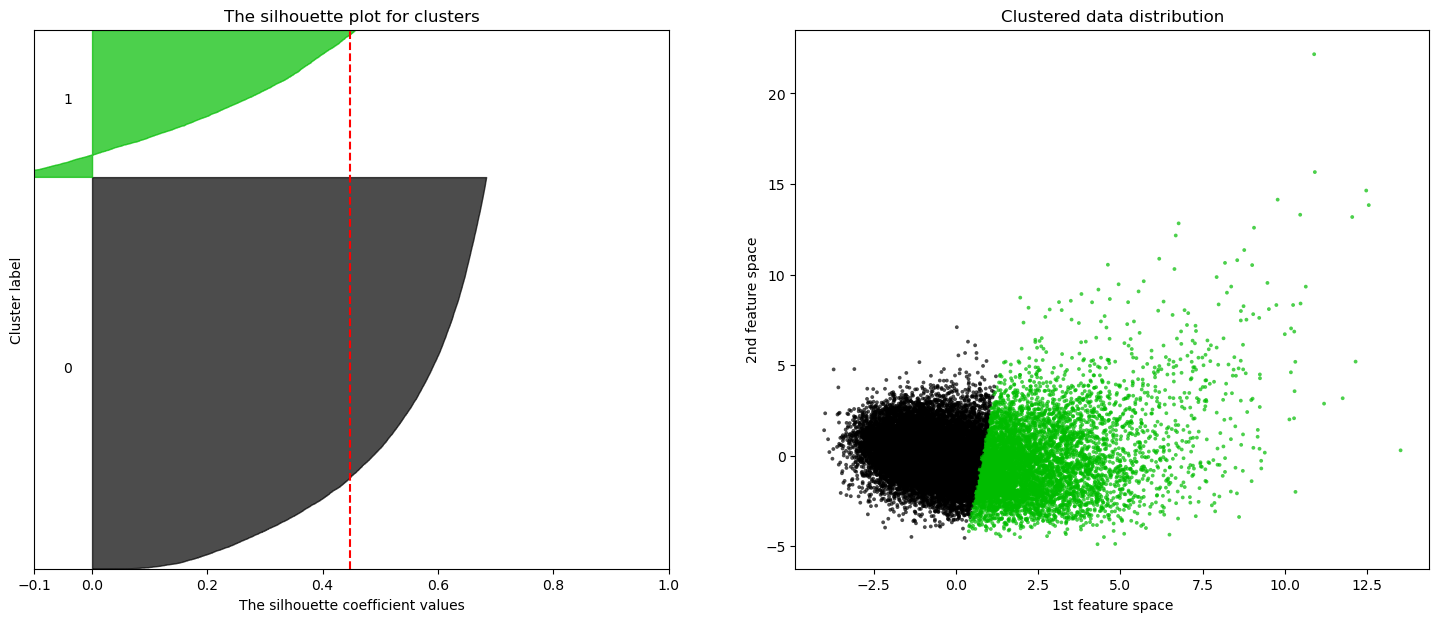

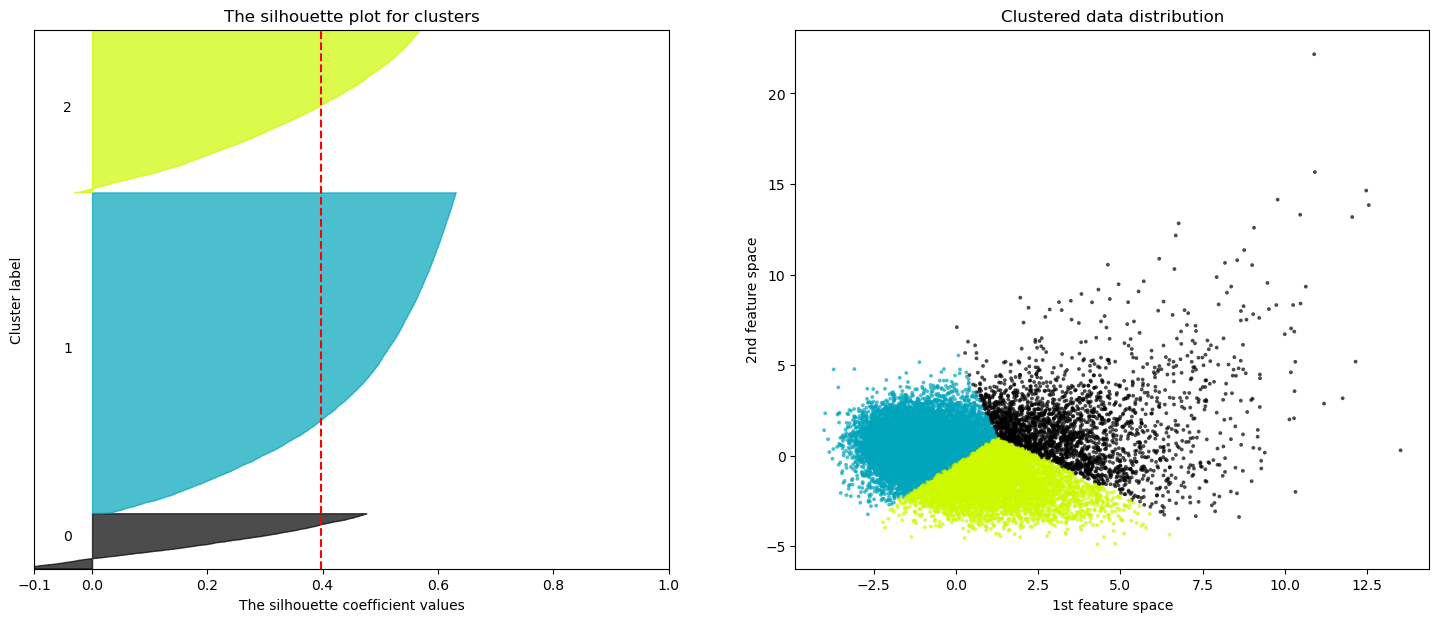

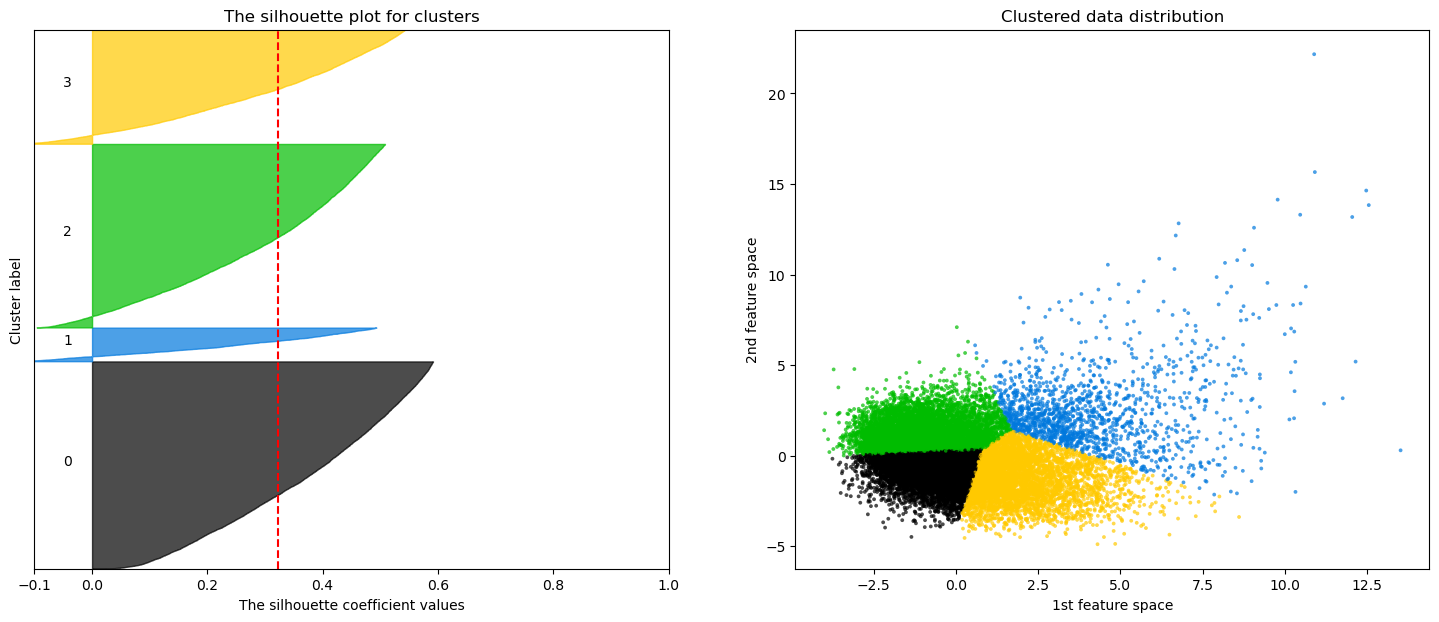

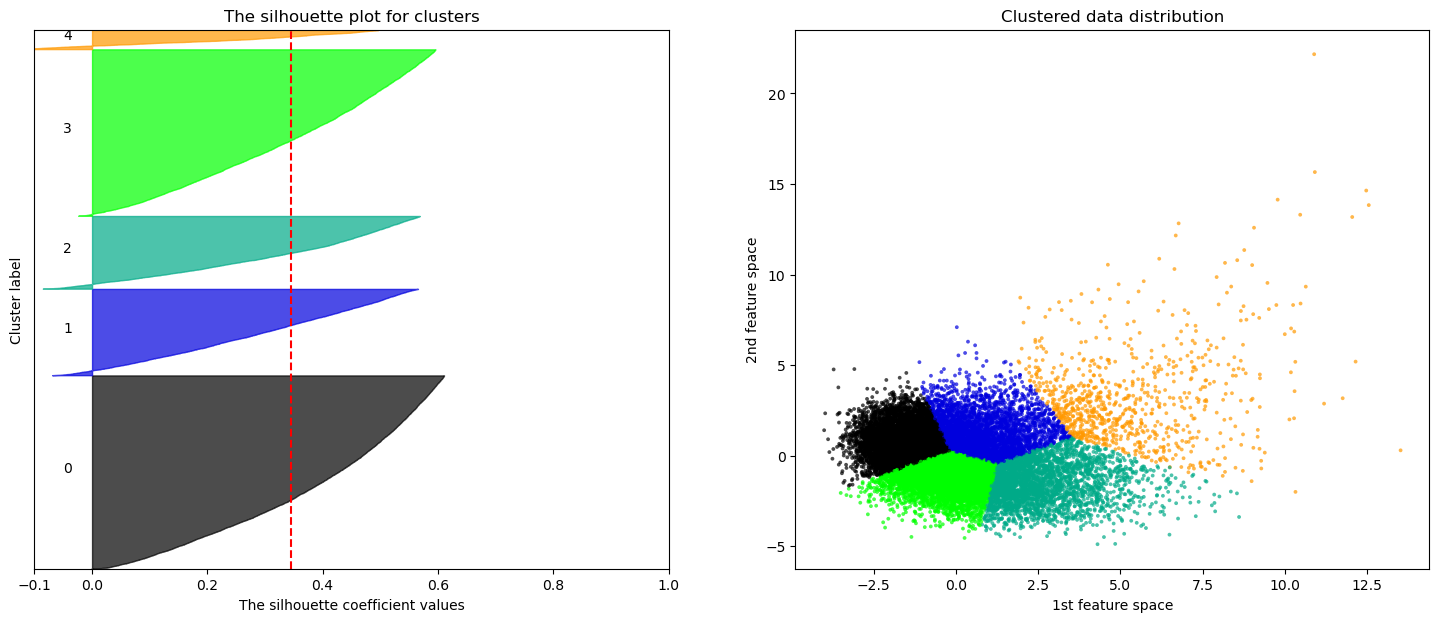

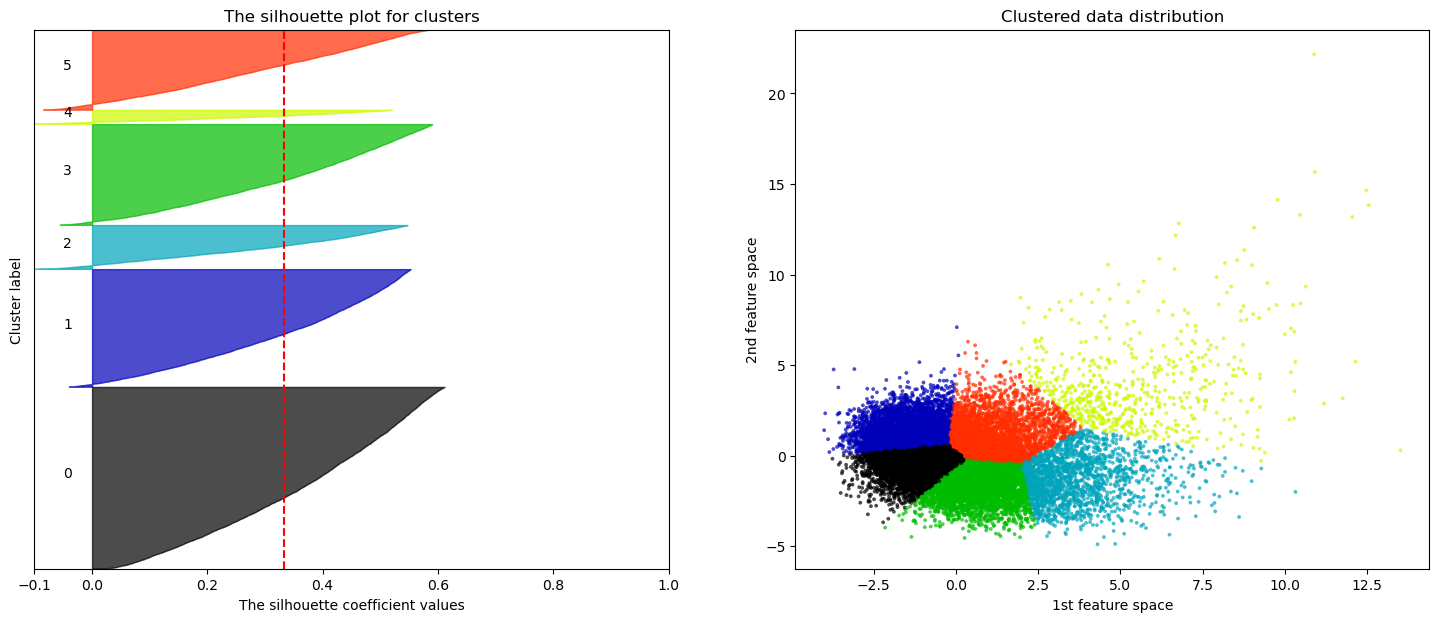

In [122]:
range_clusters = [2, 3, 4, 5, 6]

for n in range_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7) 
    
    # ax1 is silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df1_pca)+ (n+1)*10])
    
    clusterer = KMeans(n_clusters=n, init="k-means++",
                n_init=50, max_iter=500, random_state=42)
    cluster_label = clusterer.fit_predict(df1_pca)
    
#   compute the silhouette score
    silhouette_avg = metrics.silhouette_score(df1_pca, cluster_label)
    print(f'For {n} clusters, average silhouette score is {silhouette_avg}')
    
    sample_silhouette = metrics.silhouette_samples(df1_pca, cluster_label)
    y_lower = 10
    for i in range(n):
        cluster_silhouette_values = sample_silhouette[cluster_label == i]
        cluster_silhouette_values.sort()
        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower+0.5*size_cluster_i, str(i))
        y_lower = y_upper + 10
        
    ax1.set_title("The silhouette plot for clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # ax2 is cluster plot
    colors = cm.nipy_spectral(cluster_label.astype(float) / n)
    ax2.scatter(df1_pca[:,0], df1_pca[:,1], marker=".",
               c=colors, alpha=0.7, s=30, lw=0, edgecolor="k")    
    ax2.set_title("Clustered data distribution")
    ax2.set_xlabel("1st feature space")
    ax2.set_ylabel("2nd feature space")
    
    plt.savefig(f'silhouette_analysis_n_clusters_{n}.png', dpi=300, bbox_inches='tight')
    
plt.show()

# Analysis of established clusters (K=3)

In [133]:
# add clinical outcome variables from the original dataset
df1['sofa'] = df['sofa_score']
df1['hospital_death'] = df['hospital_expire_flag']
df1['los_icu'] = df['los_icu']
df1['los_hosp'] = df['los_hospital']

In [137]:
df1 = df1.assign(hospital_death = lambda x: pd.Categorical(x['hospital_death']))

In [147]:
# output the descriptive summary
grouped = df1.groupby('label')
table = grouped.describe(include=[np.number, 'category']).T
table.to_excel('descriptive_labels.xlsx')

<Figure size 800x600 with 0 Axes>

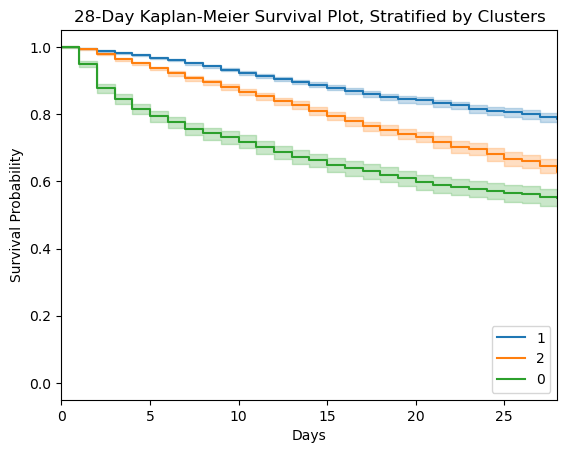

In [164]:
# 28 day Kaplan-Meier survival plot
kmf = KaplanMeierFitter()

figkm = plt.figure(figsize=(8, 6))
figkm, ax = plt.subplots(1, 1)

for label in df1['label'].unique():
    # Subset to the group
    group = df1[df1['label'] == label]   
    # Fit the model for the group
    kmf.fit(group['los_hosp'], group['hospital_death'], label=label)    
    kmf.plot_survival_function()

ax.set_xlim([0, 28])
ax.legend(loc="lower right")
plt.title('28-Day Kaplan-Meier Survival Plot, Stratified by Clusters')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.show()

In [160]:
figkm.savefig('survival.png', dpi=300, bbox_inches='tight')